# README

This notebook is a part of the reproducibility repository for the paper "Cohort-level analysis of human de novo mutations points to drivers of clonal expansion in spermatogonia." The notebook contains a variety of quality control procedures for the mutation rate model Roulette at the site and at the gene level. In particular:

**1. Per-Site Analysis**  
Plot observed-to-expected synonymous *de novo* variant counts and calculate variance inflation using Poisson-Negative Binomial comparison.

**2. Variance Inflation**  
Estimate raw regression-based second moment inflation and compare Poisson and Negative Binomial models.

**3. Per-Gene Analysis**  
Calculate variance inflation for synonymous sites using regression framework and Poisson-Negative Binomial test.

**4. Model Fit Visualization**  
Visually inspect Poisson fit to per-gene synonymous variant counts.

**5. Negative Binomial Fit**  
Fit Negative Binomial model to observed per-gene synonymous mutation counts and compare likelihoods with Poisson.

**6. Overdispersion of Per-Gene Estimates**  
Assess effects of regionally correlated residuals and test significance using the $\chi^2$ statistic.

See the Methods section of the paper for details.

# Dependencies

The following Python libraries are required for this notebook:

- `pandas`: For data manipulation and analysis.
- `numpy`: For numerical computations.
- `matplotlib.pyplot`: For creating plots and visualizations.
- `scipy.stats`: For statistical distributions and tests.
- `scipy.optimize`: For optimization tasks like minimizing functions.
- `gzip`: For handling compressed files.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, nbinom, poisson, chi2
from scipy.optimize import minimize


In [43]:
### Required files ###
# The list of files presented here is available online along with the code


# Table containing the observed and expected Roulette rates for synonymous variants in the NDD cohort from Kaplanis et al., 2020
site_syn_file = "Syn_rate_NDD.txt"

# Table containing the observed and expected Roulette rates for synonymous variants in the NDD cohort startified by gene from Kaplanis et al., 2020
site_gene_syn_file = "Syn_rate_NDD_gene.txt"

# Table containing the observed and expected Roulette rates for synonymous variants in the NDD cohort startified by gene from Kaplanis et al., 2020
syn_file = "S_NDDID_GM_allvars_denovo_cohort_recurrence.txt"

# File containing the counts of specific roulette bins within each gene
gene_MR_pars_cnts = "gene_MR_pair_counts.txt.gz"


In [16]:
# Frequency of MRs of synonymous variants
df_MR_freq = pd.read_table(site_syn_file, sep=" ")

df_MR_freq = df_MR_freq[df_MR_freq["rec"] == 0].reset_index(drop=True)
MR_cnt_dict = {float(df_MR_freq["Roul"][i]) : df_MR_freq["muts"][i] for i in range(len(df_MR_freq))}

# 1. Prediction of per-site synonymous <i>de novo</i> rates



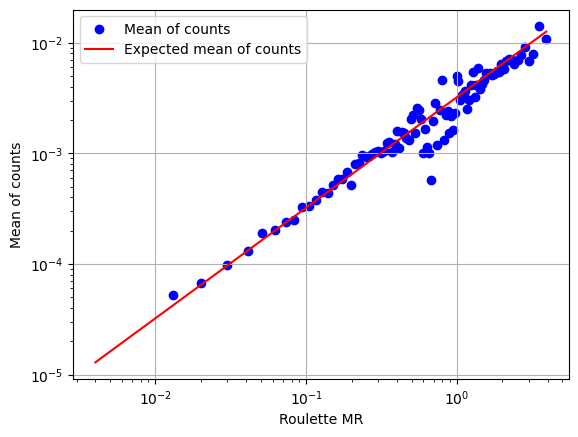

In [17]:
# Read the data from the file containing observed and expected rates for synonymous variants
SYN_df = pd.read_csv(site_gene_syn_file, sep=" ")

# Create a new column "Obj_recurr" to store the observed recurrence values for NDD
SYN_df["Obj_recurr"] = SYN_df["NDD"]

# Get the unique mutation rates (MRs) from the dictionary keys
MRs = sorted(MR_cnt_dict.keys())

# Function to calculate the mean and variance of recurrence counts in a bin
def bin_count_moments(bin_count_dict):
    values = np.array(sorted(bin_count_dict.keys()))  # Unique recurrence values
    Ps = np.array([bin_count_dict[k] for k in values])  # Frequencies of recurrence values
    Ps = Ps / np.sum(Ps)  # Normalize frequencies to probabilities

    mean = np.sum(values * Ps)  # Calculate mean
    var = np.sum((values - mean) ** 2 * Ps)  # Calculate variance

    # Handle cases where mean is zero
    if mean == 0:
        mean = np.nan
        var = np.nan

    return mean, var

# Initialize dictionaries and lists to store results
bin_count_dict = {}
cond_avgs = []  # conditional averages
cond_vars = []  # conditional variances
MR_probs = []   # probabilities of mutation rate

# Initialize total values for mutation rates and de novo counts
MR_total_val = 0
de_novo_total_val = 0

# Iterate over each mutation rate (MR)
for MR in MRs:
    # Filter the dataframe for the current MR
    MR_df = SYN_df[SYN_df["Roul"] == MR].reset_index(drop=True)
    
    # Get unique recurrence values for the current MR
    recurr_vals = MR_df["Obj_recurr"].unique()
    
    # Initialize a dictionary to store recurrence counts for the current MR
    bin_count_dict[MR] = {}
    poly_poss_n = 0  # Counter for polymorphic positions
    
    # Iterate over each recurrence value
    for i in recurr_vals:
        if i == 0:  # Skip recurrence value 0
            continue
        
        # Filter the dataframe for the current recurrence value
        k_MR_df = MR_df[MR_df["Obj_recurr"] == i].reset_index(drop=True)
        
        # Count the number of occurrences of the current recurrence value
        k = len(k_MR_df)
        bin_count_dict[MR][int(i)] = int(k)  # Store the count in the dictionary
        poly_poss_n += k  # Update the polymorphic positions counter
    
    # Append the probability of the current MR to the list
    MR_probs.append(MR_cnt_dict[MR])

    # Calculate the count of recurrence value 0
    bin_count_dict[MR][0] = int(MR_cnt_dict[MR] - poly_poss_n)

    # Calculate the mean and variance for the current MR
    cond_avg, cond_var = bin_count_moments(bin_count_dict[MR])

    # Append the results to the respective lists
    cond_avgs.append(cond_avg)
    cond_vars.append(cond_var)

    # Update the total values for mutation rates and de novo counts
    MR_total_val += MR_cnt_dict[MR] * MR
    de_novo_total_val += MR_cnt_dict[MR] * cond_avg if not np.isnan(cond_avg) else 0

# Plot the results
plt.scatter(MRs, cond_avgs, c="blue", label="Mean of counts")  # Scatter plot of MRs vs conditional averages
# Plot the expected mean of counts as a red line
x = np.array([np.min(MRs), np.max(MRs)])
plt.plot(x, x * de_novo_total_val / MR_total_val, c="red", label="Expected mean of counts")
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Roulette MR")
plt.ylabel("Mean of counts")
plt.legend()
plt.grid()
plt.show()

# 2. Overdispersion of per-site estimates

Here, we calculate the raw deviation of the observed variance from the Poisson expectation given by the mean

In [30]:
# Normalize factor for mutation rates
norm_fac = de_novo_total_val / MR_total_val

# Normalize mutation rates
MRs_norm = np.array(MRs) * norm_fac

# Initialize total mean and variance
total_mean = 0
total_var = 0

# Iterate over each mutation rate (MR)
for MR in MRs:
    # Get the bin count dictionary for the current MR
    bcd = bin_count_dict[MR]

    vals = np.array(sorted(bcd.keys()))
    
    # probabilities of recurrence values
    Ps = np.array([bcd[k] for k in vals])
    Ps = Ps / np.sum(Ps)  # Normalize to probabilities

    # Variance for the current MR
    var = np.sum((vals - MRs_norm[MRs.index(MR)]) ** 2 * Ps) * MR_cnt_dict[MR]
    
    # Calculate mean for the current MR
    mean = MRs_norm[MRs.index(MR)] * MR_cnt_dict[MR]

    # Update total mean and variance
    total_mean += mean
    total_var += var

# Print the results
print("Total mean:", total_mean) 
print("Total variance:", total_var) 
print("Total variance - Total mean:", total_var - total_mean)  # Raw variance inflation
print(r"Variance inflation $\gamma$:", total_var / total_mean - 1)  # Scaled variance inflation factor

Total mean: 7740.999999999995
Total variance: 7772.364070578935
Total variance - Total mean: 31.36407057893939
Variance inflation $\gamma$: 0.00405168202802475


# 3. Negative Binomial fit to per-site mutation count distribution

Here, we are using the parametrization of the Negative Binomial with the mean and the parameter of variance inflation relative to Poisson $\gamma$. For the counts of per-site synonymous variants we:
1. Compare two likelihoods: the Poisson


$\mathcal{L}_0 = \prod_{v \in S} e^{-\lambda_v} \frac{\lambda_v^{n_v}}{n_v !}$

and the Negative Binomial:

$\mathcal{L}_{\gamma} = \prod_{v \in S} {n_v + \frac{\lambda_v}{\gamma} - 1 \choose n_v} \left(\frac{\gamma}{\gamma + 1} \right)^{n_v} \left(\frac{1}{\gamma + 1} \right)^{\frac{\lambda_v}{\gamma}}$

using the Akaike information criterion (AIC) for extra parameter $\gamma$.

2. Choose the Negative Binomial model as the one producing the best fit according to AIC

3. Choose the largest $\gamma$ value among the maximum likelihood and the raw variance inflation ones

see the Methods section of the paper for details.


In [38]:
# Raw variance inflation
# Calculate raw variance inflation gamma
regr_gamma = total_var / total_mean - 1

def Poisson_LL(MRs, bin_count_dict, MRs_norm):
    LL = 0  # Init LL
    for MR in MRs:
        # Calculate the Poisson mean
        Poisson_mean = MRs_norm[MRs.index(MR)]

        # Update the log-likelihood for the current MR
        for k, cnt in bin_count_dict[MR].items():
            LL += cnt * poisson.logpmf(k, Poisson_mean)
    return LL

# Define a function to calculate the Negative Binomial log-likelihood
def NB_gamma_LL(MRs, bin_count_dict, MRs_norm, gamma):
    LL = 0  # Init LL
    for MR in MRs:
        # Calculate standard NB parameters
        NB_mean = MRs_norm[MRs.index(MR)]
        NB_r = NB_mean / gamma
        NP_p = 1 / (1 + gamma)

        # Update the log-likelihood for the current MR
        for k, cnt in bin_count_dict[MR].items():
            LL += cnt * nbinom.logpmf(k, NB_r, NP_p)
    return LL

# Perform optimization to find the Maximum Likelihood estimate of gamma
ML_gamma = minimize(
    lambda x: -NB_gamma_LL(MRs, bin_count_dict, MRs_norm, x),
    x0=0.004,  # Initial guess for gamma obtained from the regression model
    bounds=((0.0001, None),),  # Bounds for gamma (must be positive and not near the computational limit)
    method="L-BFGS-B"  # Optimization method
).x[0]

# Print the likelihoods for Poisson and ML estomate of gamma
pois_LL = Poisson_LL(MRs, bin_count_dict, MRs_norm)
NB_LL = NB_gamma_LL(MRs, bin_count_dict, MRs_norm, ML_gamma)
print("Poisson LL:", pois_LL)
print("ML Negative Binomial LL with gamma =", ML_gamma, ":", NB_LL)
print("LLR", "Poisson vs NB with gamma =", ML_gamma, ":", (NB_LL - pois_LL))

# AIC values
AIC_pois = -2 * pois_LL + 2 * 1  # Poisson model has 1 parameter (mean)
AIC_NB = -2 * NB_LL + 2 * 1  # Negative Binomial model has 1 parameter (gamma)
print("\nAIC for Poisson model:", AIC_pois)
print("AIC for Negative Binomial model with gamma =", ML_gamma, ":", AIC_NB)
print("AIC difference (Poisson - NB):", AIC_pois - AIC_NB)

# Print the results
print("\nRaw variance inflation gamma:", regr_gamma)
print("ML variance inflation gamma:", ML_gamma)
print("gamma used:", ML_gamma if ML_gamma > regr_gamma else regr_gamma)  

Poisson LL: -61722.322791150575
ML Negative Binomial LL with gamma = 0.004390942323358839 : -61690.8407696517
LLR Poisson vs NB with gamma = 0.004390942323358839 : 31.4820214988722

AIC for Poisson model: 123446.64558230115
AIC for Negative Binomial model with gamma = 0.004390942323358839 : 123383.6815393034
AIC difference (Poisson - NB): 62.9640429977444

Raw variance inflation gamma: 0.00405168202802475
ML variance inflation gamma: 0.004390942323358839
gamma used: 0.004390942323358839


# 4. Overdispersion of per-gene estimates

Here, we check for the effects of regionally correlated Roulette residuals, which should lead to genes having systematically over- or underpredicted mutation rates. First, we use the regression model for overdispersion of per-gene mutation rates $\lambda_g$:

$\mathrm{Var}(n_g) = \mathbb{E}[\mathrm{Var}(n_g \mid \lambda_g)] + \mathrm{Var}[\mathbb{E}(n_g \mid \lambda_g)],$

$\mathrm{Var}(n_g) = \mathbb{E}(\lambda_g) + \mathrm{Var}(\lambda_g)$.

And assess significance using the $\chi^2$ test on

$\chi^2 = \sum_g \frac{(n_g - \lambda_g)^2}{\lambda_g}$



In [44]:
syn_file = "S_NDDID_GM_allvars_denovo_cohort_recurrence.txt"

df = pd.read_csv(syn_file, sep="\t")

syncount_dict = {df["ensembl_gene_id"][i] : len(df["file_names"][i].split(",")) for i in range(len(df))}

Per_gene_MR_cnts = pd.read_table(gene_MR_pars_cnts, compression="gzip", sep="\t", header=None)

# Read the data from the file containing observed and expected rates for synonymous variants
SYN_df = pd.read_csv(site_gene_syn_file, sep=" ")

In [ ]:
# dictionary to store mutation target values for each gene
ENS2muttarg_dict = {}
for i in range(len(Per_gene_MR_cnts)):
    if not ENS2muttarg_dict.get(Per_gene_MR_cnts[1][i]):
        ENS2muttarg_dict[Per_gene_MR_cnts[1][i]] = 0
    # Update the mutation target value for the gene
    ENS2muttarg_dict[Per_gene_MR_cnts[1][i]] += Per_gene_MR_cnts[0][i] * Per_gene_MR_cnts[2][i] * de_novo_total_val / MR_total_val

# Now, let's calculate the mean and variance of the counts for each gene
ks = []  # List to store observed counts for each gene
mts = []  # List to store mutation target values for each gene
for ENS_ID in sorted(ENS2muttarg_dict.keys()):
    # Get the observed count for the gene, default to 0 if not present
    k = syncount_dict.get(ENS_ID, 0)
    ks.append(k)  # Append the observed count
    mts.append(ENS2muttarg_dict[ENS_ID])  # Append the mutation target value

In [50]:
mts = np.array(mts)  
total_mean = np.mean(ks)  # Cmean of observed counts
total_var = np.mean(np.power(ks - mts, 2))  # variance of observed counts
print("Total mean", total_mean)  
print("Total var", total_var)  
print("Total var / Total mean", total_var / total_mean)  

print("\nRaw mt mean", np.mean(mts))  # Print the mean of mutation target values

mts = np.array(mts) * np.mean(ks)/np.mean(mts)  # Normalize mutation target values

k_var_raw = np.sum(np.power(ks - np.mean(ks), 2))  # raw variance of observed counts
mt_var_raw = np.sum(np.power(mts - np.mean(mts), 2))  # raw variance of mutation target values
k_cond_mt_var = np.sum(np.power(ks - mts, 2))  # cond variance

print("Raw k variance", k_var_raw)  
print("Raw mt variance", mt_var_raw)  
print("\nConditional variance", k_cond_mt_var) 
print("unexplained variance", k_var_raw - k_cond_mt_var - mt_var_raw)

Total mean 0.4795695308558937
Total var 0.4948811435883019
Total var / Total mean 1.0319278264094078

Raw mt mean 0.4795695308558938
Raw k variance 13894.803093996974
Raw mt variance 4958.542638714901

Conditional variance 8829.174482758894
unexplained variance 107.08597252317941


In [56]:
# ks = observed counts
# mts = expected Poisson means
residuals = (ks - mts) ** 2 / mts
X2 = np.sum(residuals)

df = len(ks) - 1  # Degrees of freedom: number of genes - 1
p_value = 1 - chi2.cdf(X2, df)

print("Chi-squared stat:", X2)
print("p-value for overdispersion:", p_value)

Chi-squared stat: 17790.04887131859
p-value for overdispersion: 0.6030156344568113


# 5. Negative Binomial fit to the observed per-gene synonymous mutation counts

Here, we do the same thing as for the individual variants above: we compare the likelihoods of Poisson and Negative Binomial fits

In [57]:
LL_Pois = np.sum(np.log(poisson.pmf(ks, mts)))

gamma = 0.015277867251544841



def objective_function(gamma):
    LL = 0
    for k, mt in zip(ks, mts):
        NB_r = mt / gamma
        NP_p = 1 / (1 + gamma)
        LL += nbinom.logpmf(k, NB_r, NP_p)
    return -LL  # We minimize, so return negative log-likelihood
result = minimize(objective_function, x0=0.01, bounds=[(1e-8, None)])
gamma = result.x[0]

print("Optimized gamma:", gamma)
# Calculate the log-likelihood for the negative binomial distribution
NB_r = mts / gamma
NP_p = 1 / (1 + gamma)

LL_NB = np.sum(nbinom.logpmf(ks, NB_r, NP_p))

print("LL Poisson:", LL_Pois)
print("LL NB:", LL_NB)
print("LL difference:", LL_NB - LL_Pois)

Optimized gamma: 0.013300436545583773
LL Poisson: -14062.414802100591
LL NB: -14061.719902398701
LL difference: 0.6948997018898808


# 6. Visual inspection of the Poisson fit

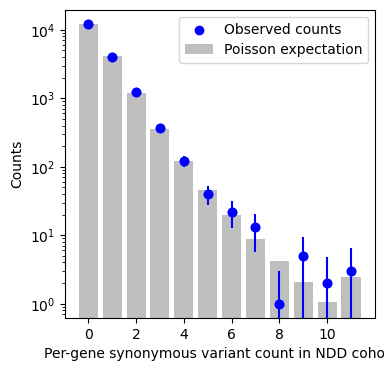

In [60]:
# range of x values for plotting
x = np.arange(0, 50, 1)

# array for Poisson probability density function (PDF)
poisson_pdf = np.zeros(len(x))

# Calculate the Poisson PDF
for mt in mts:
    poisson_pdf += poisson.pmf(x, mt)

plt.figure(figsize=(4, 4))

# Collapse the points after x=10 in the Poisson PDF for better visualization
poisson_pdf = np.concatenate((poisson_pdf[:11], [np.sum(poisson_pdf[11:])]))

# Update x to match the collapsed Poisson PDF
x = np.arange(0, 12, 1)

# Plot the Poisson expectation as a bar chart
plt.bar(x, poisson_pdf, color="grey", label="Poisson expectation", alpha=0.5, width=0.8)

plt.xlabel("Per-gene synonymous variant count in NDD cohort")
plt.ylabel("Counts")

# Get the unique observed counts (ks) and their frequencies (ks_vals)
ks_counts, ks_vals = np.unique(ks, return_counts=True)

# Collapse the points after x=10 in the observed counts and frequencies
ks_counts = np.concatenate((ks_counts[:11], [11]))
ks_vals = np.concatenate((ks_vals[:11], [np.sum(ks_vals[11:])]))

# Add error bars to represent ~95% confidence intervals for the observed counts
plt.errorbar(ks_counts, ks_vals, yerr=2 * np.sqrt(ks_vals), fmt='o', color='blue')

# Scatter plot the observed counts
plt.scatter(ks_counts, ks_vals, color="blue", label="Observed counts")


plt.yscale("log")
plt.legend()
plt.savefig("syn_counts_poisson_fit.pdf", bbox_inches="tight")
plt.show()
